# Diagrama de Voronoi – Droguerías en Sogamoso

Este ejercicio corresponde al **punto 3 del taller** de la asignatura *Inteligencia Artificial y Minirobots* de la Universidad Nacional de Colombia.  
El objetivo es aplicar herramientas de análisis espacial para visualizar la **distribución geográfica de droguerías** en la ciudad de **Sogamoso (Boyacá)** mediante un **diagrama de Voronoi**.

### Descripción técnica

- Se recolectaron **coordenadas geográficas (latitud, longitud)** de **16 droguerías** ubicadas en distintos sectores de la ciudad.
- Las coordenadas fueron **obtenidas manualmente desde Google Maps**, verificando y anotando cada ubicación de forma individual.
- Se utilizó la librería `scipy.spatial.Voronoi` para construir las regiones de influencia de cada punto (cada droguería).
- Las coordenadas fueron transformadas a formato 2D (`x = longitud`, `y = latitud`) para graficar el diagrama con `matplotlib`.
- Se implementó una técnica para **cerrar las regiones infinitas** del diagrama y recortarlas dentro de un **bounding box** (marco geográfico definido), asegurando que todas las celdas sean visibles y finitas.
- Cada punto está marcado en azul y etiquetado con el nombre de la droguería correspondiente.

### Propósito del análisis

Este tipo de análisis permite:

- Identificar **zonas con baja cobertura farmacéutica**.
- Proponer ubicaciones estratégicas para nuevos establecimientos.
- Apoyar la **planificación urbana y comercial** en el sector salud.

---

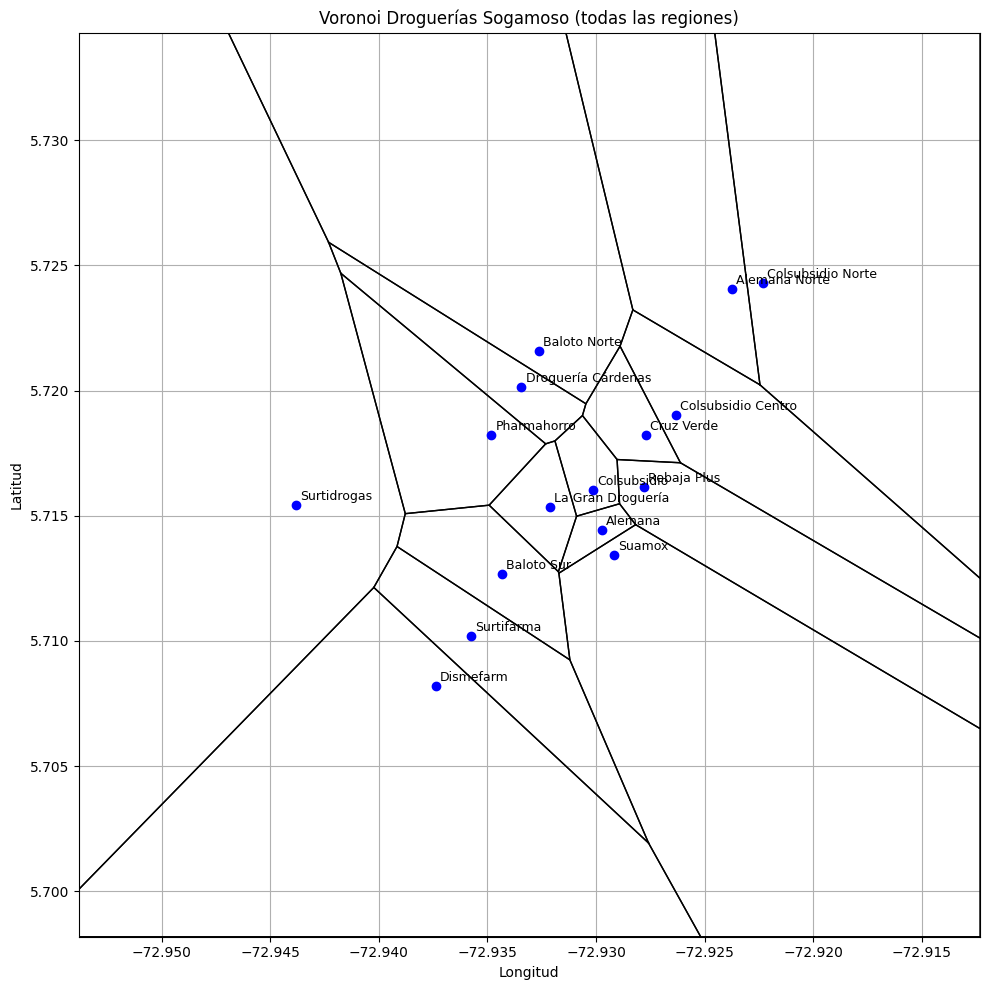

In [16]:
#FRANCISCO JOSSE ROJAS ROJAS
#YEIRA LISETH RODRIGUEZ RODRIGUEZ
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
import matplotlib.patches as patches
from shapely.geometry import Polygon, LineString, Point

# Coordenadas (lat, lon)
locs = {
    "Dismefarm":           [5.708189216333151, -72.93737919890503],
    "Surtifarma":          [5.710182099618657, -72.93577087539333],
    "Baloto Sur":          [5.712688291486838, -72.93434462624145],
    "Surtidrogas":         [5.715436031413964, -72.94381249295182],
    "Pharmahorro":         [5.718213952878581, -72.93483015786762],
    "Droguería Cárdenas":  [5.720146412030573, -72.93343425444239],
    "Baloto Norte":        [5.721595752110227, -72.93264526554985],
    "La Gran Droguería":   [5.715345446791387, -72.93212938819704],
    "Suamox":              [5.7134431664067495, -72.92918585271337],
    "Alemana":             [5.714439599777382, -72.92973207579281],
    "Colsubsidio":         [5.716009733690705, -72.93012657023908],
    "Rebaja Plus":         [5.716160707878493, -72.92778994928813],
    "Cruz Verde":          [5.718213952878581, -72.92769891210823],
    "Colsubsidio Centro":  [5.719029209879362, -72.9263333544096],
    "Alemana Norte":       [5.724071699581389, -72.92375396764557],
    "Colsubsidio Norte":   [5.724283060454115, -72.92232771849368]
}

# Convertir a (x, y) = (lon, lat)
points_latlon = np.array(list(locs.values()))
points = np.array([[lon, lat] for lat, lon in points_latlon])
vor = Voronoi(points)

# Bounding box manual
margin = 0.01
xmin, xmax = points[:,0].min() - margin, points[:,0].max() + margin
ymin, ymax = points[:,1].min() - margin, points[:,1].max() + margin
bbox = Polygon([(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)])

# Crear regiones Voronoi cerradas
def finite_polygons(vor, radius=1):
    regions = []
    center = points.mean(axis=0)
    new_vertices = vor.vertices.tolist()
    all_ridges = {}

    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region_idx in enumerate(vor.point_region):
        region = vor.regions[region_idx]
        if not region:
            continue
        if -1 not in region:
            polygon = [vor.vertices[i] for i in region]
            regions.append((p1, Polygon(polygon).intersection(bbox)))
            continue

        ridges = all_ridges[p1]
        region_pts = []

        for p2, v1, v2 in ridges:
            if v1 == -1 or v2 == -1:
                finite_v = v2 if v1 == -1 else v1
                tangent = points[p2] - points[p1]
                tangent = tangent / np.linalg.norm(tangent)
                normal = np.array([-tangent[1], tangent[0]])
                midpoint = (points[p1] + points[p2]) / 2
                direction = np.sign(np.dot(midpoint - center, normal)) * normal
                far_point = vor.vertices[finite_v] + direction * radius
                new_vertices.append(far_point.tolist())
                region_pts.append(vor.vertices[finite_v])
                region_pts.append(far_point)
            else:
                region_pts.append(vor.vertices[v1])
                region_pts.append(vor.vertices[v2])

        polygon = Polygon(region_pts).convex_hull
        clipped = polygon.intersection(bbox)
        regions.append((p1, clipped))
    return regions

regions = finite_polygons(vor, radius=0.05)

# Graficar
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor("white")

for idx, poly in regions:
    if poly.is_empty: continue
    x, y = poly.exterior.xy
    ax.plot(x, y, color='black', linewidth=1)

# Dibujar puntos y nombres
for name, (lat, lon) in locs.items():
    ax.plot(lon, lat, 'bo')
    ax.text(lon + 0.0002, lat + 0.0002, name, fontsize=9)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
ax.set_title("Voronoi Droguerías Sogamoso (todas las regiones)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Mapa interactivo con `folium`

Con el fin de complementar la visualización del diagrama de Voronoi, se implementa un **mapa interactivo en Folium** para mostrar la ubicación exacta de las droguerías sobre un mapa real de **Sogamoso (Boyacá)**.

- Se utilizó la librería `folium` (basada en Leaflet.js) para construir el mapa sobre un fondo de **OpenStreetMap**.
- Se definió un **bounding box manual** (latitud y longitud mínimas y máximas) que coincide aproximadamente con la región cubierta por el diagrama de Voronoi anterior, asegurando consistencia visual entre ambas representaciones.
- Cada droguería fue marcada con un `folium.Marker`, incluyendo **etiquetas y pop-ups** con el nombre del establecimiento.
- El mapa es completamente interactivo: se puede hacer zoom, mover y consultar cada punto.

Esta representación permite:
- **Ubicar visualmente cada droguería** dentro del contexto urbano real de Sogamoso.
- Comparar la distribución geográfica real con las regiones teóricas generadas en el diagrama de Voronoi.

> Nota: El mapa generado en Colab se visualiza directamente en el notebook y no requiere conexión con el Voronoi, pero sirve como complemento visual.

In [22]:
!pip install folium

import folium

# Definir el bounding box manualmente (para que coincida con el Voronoi)
lat_min, lat_max = 5.700, 5.730
lon_min, lon_max = -72.950, -72.915
center = [(lat_min + lat_max) / 2, (lon_min + lon_max) / 2]

# Crear el mapa con el bounding box centralizado
m = folium.Map(location=center, zoom_start=14.3, tiles="OpenStreetMap")

# Añadir marcadores
locs = {
    "Dismefarm":           [5.708189216333151, -72.93737919890503],
    "Surtifarma":          [5.710182099618657, -72.93577087539333],
    "Baloto Sur":          [5.712688291486838, -72.93434462624145],
    "Surtidrogas":         [5.715436031413964, -72.94381249295182],
    "Pharmahorro":         [5.718213952878581, -72.93483015786762],
    "Droguería Cárdenas":  [5.720146412030573, -72.93343425444239],
    "Baloto Norte":        [5.721595752110227, -72.93264526554985],
    "La Gran Droguería":   [5.715345446791387, -72.93212938819704],
    "Suamox":              [5.7134431664067495, -72.92918585271337],
    "Alemana":             [5.714439599777382, -72.92973207579281],
    "Colsubsidio":         [5.716009733690705, -72.93012657023908],
    "Rebaja Plus":         [5.716160707878493, -72.92778994928813],
    "Cruz Verde":          [5.718213952878581, -72.92769891210823],
    "Colsubsidio Centro":  [5.719029209879362, -72.9263333544096],
    "Alemana Norte":       [5.724071699581389, -72.92375396764557],
    "Colsubsidio Norte":   [5.724283060454115, -72.92232771849368]
}

# Agregar los marcadores
for name, coords in locs.items():
    folium.Marker(location=coords, popup=name, tooltip=name).add_to(m)

# Mostrar el mapa
m